In [2]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 20.1G/20.1G [02:15<00:00, 159MB/s] 

Extracting files...


Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-dataset/versions/1


In [1]:
import csv
import os

base_url = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-dataset/versions/1"

with open(f"{base_url}/data.csv", 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['image_url', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()

    for label in os.listdir(f"{base_url}"):
        # Check if the label is a directory before trying to list its contents
        if os.path.isdir(os.path.join(base_url, label)):
            for audio_url in os.listdir(os.path.join(base_url, label)):
                writer.writerow({'image_url': f"{base_url}/{label}/{audio_url}", 'label': label})

In [2]:
!pip install transformers --q
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from transformers import AutoImageProcessor, LevitForImageClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [3]:
df = pd.read_csv(base_url+'/data.csv')
df.head()

,image_url,label
0,/teamspace/studios/this_studio/.cache/kagglehu...,ai
1,/teamspace/studios/this_studio/.cache/kagglehu...,ai
2,/teamspace/studios/this_studio/.cache/kagglehu...,ai
3,/teamspace/studios/this_studio/.cache/kagglehu...,ai
4,/teamspace/studios/this_studio/.cache/kagglehu...,ai


In [4]:
train = df.sample(frac=0.7)
test = df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape, test.shape, val.shape)

(42087, 2) (9019, 2) (9018, 2)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
# Keep torchvision transforms import if needed elsewhere, but not for main processing here
# from torchvision import transforms 
from transformers import AutoImageProcessor # Import the HF processor
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageFile
import pandas as pd
import os # For checking file existence

# Optional: Tell PIL to be more lenient with truncated images
# ImageFile.LOAD_TRUNCATED_IMAGES = True 

# Assume 'df' is your pandas DataFrame with 'image_url' and 'label' columns
# --- (Your DataFrame loading logic here) ---
# data = {'image_url': ['path/to/img1.jpg', 'path/to/img2.png', ...], 
#         'label': ['cat', 'dog', ...]}
# df = pd.DataFrame(data)


# 1. Setup LabelEncoder (fit it once on your training data labels)
label_encoder = LabelEncoder()
# Fit on the *entire* dataset's labels or at least all unique training labels
all_labels = df['label'].unique() # Or load labels from a predefined list
label_encoder.fit(all_labels) 
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


# 2. Load the AutoImageProcessor 
# !! Replace "facebook/levit-128s" with the EXACT Hugging Face checkpoint name !!
# !! corresponding to the model you plan to use.                !!
model_checkpoint = "facebook/levit-128s" # Example checkpoint
try:
    processor = AutoImageProcessor.from_pretrained(model_checkpoint)
    print(f"Loaded AutoImageProcessor for checkpoint: {model_checkpoint}")
except Exception as e:
    print(f"Error loading image processor for {model_checkpoint}: {e}")
    print("Please ensure the checkpoint name is correct and you have internet access.")
    # Handle error appropriately, maybe exit or fall back to torchvision
    processor = None # Set to None if loading fails


# 3. Define the Custom Dataset using the AutoImageProcessor
class CustomImageDataset(Dataset):
    # Pass the processor instance instead of torchvision transforms
    def __init__(self, dataframe, label_encoder_instance, image_processor=None):
        self.dataframe = dataframe
        self.image_processor = image_processor # Store the processor instance
        self.label_encoder = label_encoder_instance 
        self.encoded_labels = self.label_encoder.transform(self.dataframe['label'])
        
        # --- Data Cleaning/Verification (Optional but Recommended) ---
        # It's good practice to verify paths exist during init if possible
        # self.verify_paths() 
        # -------------------------------------------------------------

    def __len__(self):
        return len(self.dataframe) 

    # --- Optional: Add method to verify image paths ---
    # def verify_paths(self):
    #    print("Verifying image paths...")
    #    original_len = len(self.dataframe)
    #    self.dataframe['path_exists'] = self.dataframe['image_url'].apply(os.path.exists)
    #    self.dataframe = self.dataframe[self.dataframe['path_exists']].reset_index(drop=True)
    #    new_len = len(self.dataframe)
    #    if new_len < original_len:
    #        print(f"Warning: Removed {original_len - new_len} entries with missing image files.")
    # -------------------------------------------------
        
    def __getitem__(self, idx):
        # Get image path from the DataFrame (ensure column name is correct)
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('image_url')] 
        label = self.encoded_labels[idx]
        
        try:
            # Load image and ensure it's RGB
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # This might be caught by verify_paths if used, but good to keep
            # print(f"Error: Image not found at {img_path}") 
            return None, None 
        except Exception as e:
            # Catches other PIL errors like truncated images if LOAD_TRUNCATED_IMAGES=False
            # print(f"Error loading image {img_path}: {e}")
            return None, None

        # Apply image processor transformations if it exists
        if self.image_processor:
            try:
                # Process the PIL image. return_tensors='pt' gives PyTorch tensors.
                # The processor handles resize, normalization, format etc.
                processed_inputs = self.image_processor(images=image, return_tensors='pt')
                # Extract the pixel values tensor. It usually has a batch dim [1, C, H, W], 
                # so we take the first element [0] to get [C, H, W] for the dataloader.
                image_tensor = processed_inputs['pixel_values'][0] 
            except Exception as e:
                 print(f"Error processing image {img_path} with AutoImageProcessor: {e}")
                 return None, None
        else:
            # Fallback if no processor is provided (e.g., just convert to tensor)
            # You might want to raise an error or apply basic transforms here
            print("Warning: No image processor provided to dataset.")
            image_tensor = transforms.ToTensor()(image) # Example fallback

        # Convert label to tensor (still on CPU)
        label_tensor = torch.tensor(label, dtype=torch.long) 

        return image_tensor, label_tensor

# Helper function for DataLoader collation (remains the same)
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: 
        return torch.tensor([]), torch.tensor([]) 
    return torch.utils.data.dataloader.default_collate(batch)


# --- Example Usage (modify your training/validation split logic) ---

# Assume you have pandas DataFrames: train_df, val_df, test_df

if processor is not None: # Only create datasets if processor loaded successfully
    # Create dataset instances, passing the processor
    train_dataset = CustomImageDataset(dataframe=train, label_encoder_instance=label_encoder, image_processor=processor)
    val_dataset = CustomImageDataset(dataframe=val, label_encoder_instance=label_encoder, image_processor=processor)
    test_dataset = CustomImageDataset(dataframe=test, label_encoder_instance=label_encoder, image_processor=processor)

    # Create DataLoaders
    batch_size = 32 # Example
    num_workers = 4 # Adjust based on your system
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True) # pin_memory=True often helps GPU transfer
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)

    print("Datasets and DataLoaders created using AutoImageProcessor.")

else:
    print("Datasets could not be created because the image processor failed to load.")


# --- Your Training Loop ---
# The training loop structure remains the same:
# device = ...
# model = ... # IMPORTANT: Load a model compatible with the processor (e.g., from transformers library)
# optimizer = ...
# criterion = ...
# Loop through train_loader, move data to device, pass to model, calculate loss, etc.
# Loop through val_loader for evaluation.

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Number of classes: 2
Class mapping: {'ai': 0, 'real': 1}
Loaded AutoImageProcessor for checkpoint: facebook/levit-128s
Datasets and DataLoaders created using AutoImageProcessor.


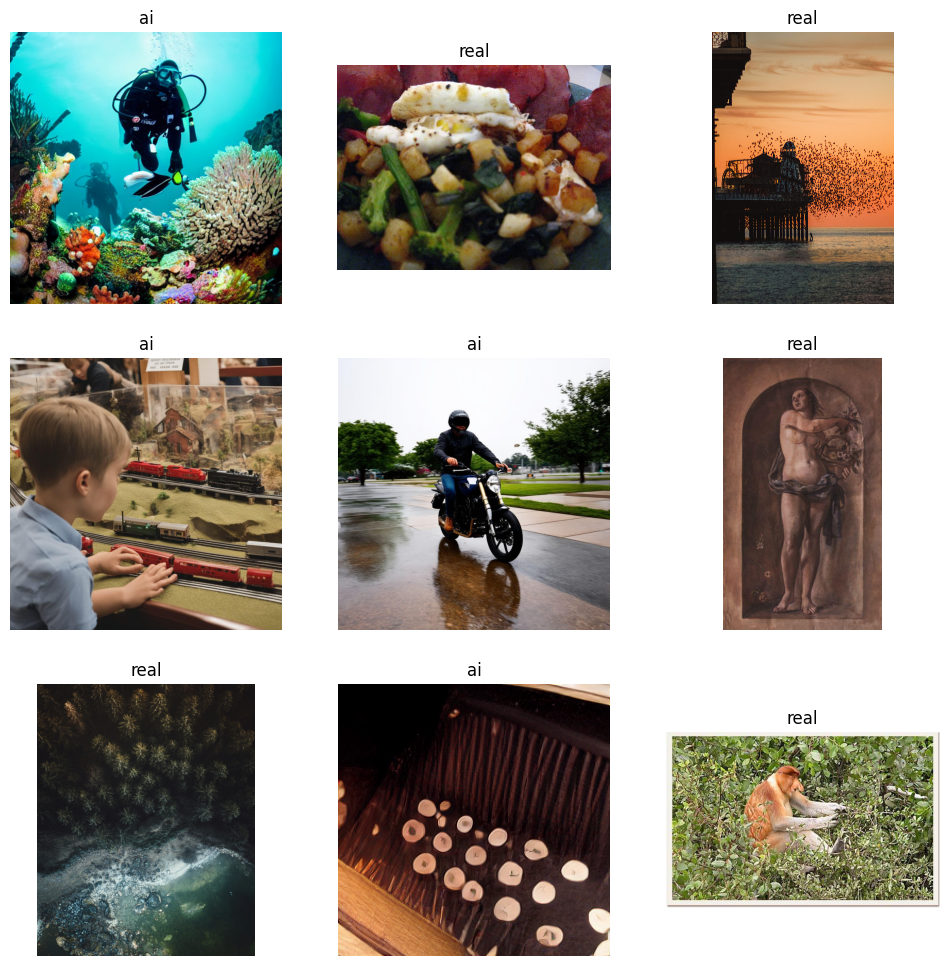

In [6]:
n_rows = 3
n_cols = 3

f, ax = plt.subplots(n_rows, n_cols, figsize=(12, 12))

for row in range(n_rows):
  for col in range(n_cols):
    smaple = df.sample(1)
    img_path = smaple['image_url'].values[0]
    label = smaple['label'].values[0]

    img = Image.open(img_path).convert('RGB')
    ax[row][col].imshow(img)
    ax[row][col].axis('off')
    ax[row][col].set_title(label)

plt.show()

In [7]:
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 15

In [8]:
!pip install timm --q
import timm

In [9]:
import torch
import torch.nn as nn
import timm

class Model(nn.Module):
    def __init__(self, num_classes=1):  # Binary classification = 1 output node
        super().__init__()

        # Load pretrained LeViT backbone (exclude default classifier head)
        self.levit = timm.create_model('levit_128s', pretrained=True, num_classes=num_classes)
        

        # Optionally freeze backbone
        freeze_backbone = True
        if freeze_backbone:
            
            for param in self.levit.parameters():
                param.requires_grad = False
        else:
            print("LeViT backbone parameters will be trainable (fine-tuning).")

        # LeViT-128s returns 384 features per token
        levit_out_features = self.levit.num_features  # Expected to be 384

        # 1x1 Conv layer to reduce features (optional)
        intermediate_features = 64
        self.conv_after_levit = nn.Conv2d(levit_out_features, intermediate_features, kernel_size=1)
        self.relu = nn.ReLU()

        # Global average pooling to [B, C, 1, 1]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final classifier head
        self.head = nn.Linear(intermediate_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        

        # Extract features (token-based output: [B, 16, 384])
        x = self.levit.forward_features(x)
        

        # Convert token-based output to a 4D feature map
        B, N, D = x.shape  # N should be 16 and D is 384
        # Transpose to [B, 384, 16]
        x = x.transpose(1, 2)
        # Reshape to [B, 384, 4, 4] assuming 16 tokens can form a 4x4 grid
        x = x.view(B, D, int(N ** 0.5), int(N ** 0.5))
        

        # Optional conv layer
        x = self.conv_after_levit(x)       # [B, 64, 4, 4]
        
        x = self.relu(x)

        # Pool: reduce spatial dimensions to [B, 64, 1, 1]
        x = self.pool(x)
        

        # Flatten: [B, 64]
        x = x.flatten(1)
        

        # Classifier: [B, num_classes]
        x = self.head(x)
        # x = x.squeeze(1)
        

        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)


In [11]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
          ConvNorm-3         [-1, 16, 112, 112]               0
         Hardswish-4         [-1, 16, 112, 112]               0
            Conv2d-5           [-1, 32, 56, 56]           4,608
       BatchNorm2d-6           [-1, 32, 56, 56]              64
          ConvNorm-7           [-1, 32, 56, 56]               0
         Hardswish-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 28, 28]          18,432
      BatchNorm2d-10           [-1, 64, 28, 28]             128
         ConvNorm-11           [-1, 64, 28, 28]               0
        Hardswish-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 14, 14]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
from torch.optim import Adam


criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [22]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

EPOCHS = 15  # or however many epochs you want to run

for epoch in range(EPOCHS):
    model.train()
    total_acc_train = 0
    total_loss_train = 0
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device).float()
 # Expected shape [B] with float values 0.0 or 1.0

        optimizer.zero_grad()
        outputs = model(inputs)  # outputs shape: [B]
        
        # Compute loss using BCEWithLogitsLoss
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        optimizer.step()

        # Compute predictions: apply sigmoid and threshold at 0.5
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_acc = (preds == labels).sum().item()
        total_acc_train += train_acc

    model.eval()
    total_loss_val = 0
    total_acc_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_acc = (preds == labels).sum().item()
            total_acc_val += val_acc

    # Compute average losses and accuracies over the dataset
    avg_train_loss = total_loss_train / len(train_loader)
    avg_val_loss = total_loss_val / len(val_loader)
    train_accuracy = (total_acc_train / len(train_dataset)) * 100
    val_accuracy = (total_acc_val / len(val_dataset)) * 100

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_loss_val_plot.append(round(avg_val_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_acc_val_plot.append(round(val_accuracy, 4))

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {total_loss_train_plot[-1]}, Val Loss: {total_loss_val_plot[-1]}, "
          f"Train Acc: {total_acc_train_plot[-1]}%, Val Acc: {total_acc_val_plot[-1]}%")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/15, Train Loss: 0.464, Val Loss: 0.5352, Train Acc: 77.6487%, Val Acc: 77.2677%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2/15, Train Loss: 0.4452, Val Loss: 0.4924, Train Acc: 79.1004%, Val Acc: 77.7556%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3/15, Train Loss: 0.4322, Val Loss: 0.4637, Train Acc: 79.8251%, Val Acc: 77.9219%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4/15, Train Loss: 0.4158, Val Loss: 0.494, Train Acc: 80.8611%, Val Acc: 78.1548%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5/15, Train Loss: 0.4036, Val Loss: 0.4777, Train Acc: 81.3957%, Val Acc: 78.4986%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6/15, Train Loss: 0.3965, Val Loss: 0.4928, Train Acc: 81.8685%, Val Acc: 78.2546%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7/15, Train Loss: 0.3879, Val Loss: 0.4852, Train Acc: 82.2487%, Val Acc: 78.4098%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8/15, Train Loss: 0.379, Val Loss: 0.4849, Train Acc: 82.7524%, Val Acc: 78.5651%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9/15, Train Loss: 0.3726, Val Loss: 0.5437, Train Acc: 83.2561%, Val Acc: 78.432%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10/15, Train Loss: 0.3672, Val Loss: 0.4916, Train Acc: 83.4034%, Val Acc: 78.9754%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11/15, Train Loss: 0.3589, Val Loss: 0.5113, Train Acc: 83.9665%, Val Acc: 77.5006%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12/15, Train Loss: 0.3551, Val Loss: 0.4855, Train Acc: 84.0687%, Val Acc: 79.0419%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13/15, Train Loss: 0.3522, Val Loss: 0.523, Train Acc: 84.3087%, Val Acc: 78.7758%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14/15, Train Loss: 0.3466, Val Loss: 0.4929, Train Acc: 84.6722%, Val Acc: 79.3635%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15/15, Train Loss: 0.3441, Val Loss: 0.5186, Train Acc: 84.5938%, Val Acc: 78.5984%


In [24]:
time = 275

In [23]:
torch.save(model.state_dict(), 'model_weights.pth')

In [25]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_loader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    outputs = model(inputs)

    batch_loss = criterion(outputs, labels)

    total_loss_test += batch_loss.item()
    pred = (torch.sigmoid(outputs) > 0.5).float()
    acc = (pred == labels).sum().item()

    total_acc_test += acc

  print(f"Test Loss: {round(total_loss_test/len(test_loader), 4)}")
  print(f"Test Accurracy: {round(total_acc_test/test_dataset.__len__() * 100, 4)}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Loss: 0.4873
Test Accurracy: 78.6451


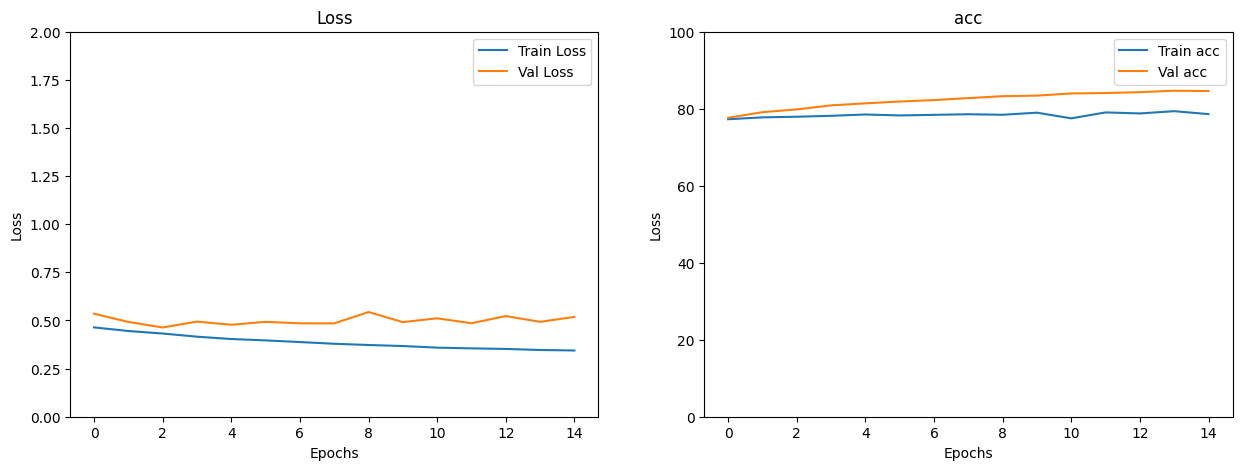

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(total_loss_train_plot, label="Train Loss")
ax[0].plot(total_loss_val_plot, label="Val Loss")
ax[1].plot(total_acc_val_plot, label="Train acc")
ax[1].plot(total_acc_train_plot, label="Val acc")
ax[0].set_title("Loss")
ax[1].set_title("acc")
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Loss")
ax[0].set_ylim([0,2])
ax[1].set_ylim([0,100])
ax[0].legend()
ax[1].legend()

plt.show()

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-test-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.15G/1.15G [00:08<00:00, 143MB/s] 

Extracting files...


Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-test-dataset/versions/2


In [17]:
path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-test-dataset/versions/2/teamspace/studios/this_studio/attacked_images"
for i in os.listdir(path):
    print(i)

3669.jpg
3322.jpg
1858.jpg
3806.jpg
2078.jpg
2273.jpg
3439.jpg
4690.jpg
1191.jpg
438.jpg
759.jpg
2467.jpg
344.jpg
2633.jpg
1305.jpg
1297.jpg
865.jpg
2060.jpg
2259.jpg
4916.jpg
4109.jpg
2908.jpg
4656.jpg
924.jpg
2559.jpg
1511.jpg
3989.jpg
2305.jpg
3997.jpg
1041.jpg
2085.jpg
4537.jpg
1723.jpg
4022.jpg
699.jpg
4795.jpg
1176.jpg
752.jpg
2225.jpg
4767.jpg
2485.jpg
4727.jpg
3995.jpg
2970.jpg
3946.jpg
2696.jpg
778.jpg
1362.jpg
440.jpg
542.jpg
901.jpg
3720.jpg
634.jpg
308.jpg
32.jpg
1781.jpg
226.jpg
1954.jpg
3041.jpg
1722.jpg
2276.jpg
346.jpg
2404.jpg
2981.jpg
2720.jpg
874.jpg
2122.jpg
4568.jpg
328.jpg
1446.jpg
4479.jpg
908.jpg
4536.jpg
4874.jpg
3491.jpg
3963.jpg
4738.jpg
3884.jpg
359.jpg
1679.jpg
3002.jpg
680.jpg
574.jpg
2553.jpg
956.jpg
3574.jpg
3691.jpg
1422.jpg
1706.jpg
1985.jpg
2487.jpg
3013.jpg
3385.jpg
4499.jpg
3554.jpg
802.jpg
930.jpg
1222.jpg
669.jpg
123.jpg
3350.jpg
3225.jpg
3625.jpg
12.jpg
3135.jpg
2599.jpg
2026.jpg
796.jpg
4659.jpg
4737.jpg
3154.jpg
2833.jpg
2572.jpg
4188.jpg
1561.

In [22]:
import os
import csv
import torch
from PIL import Image
from transformers import AutoImageProcessor

# Define the directory containing images and model checkpoint
test_base_url = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-test-dataset/versions/2/teamspace/studios/this_studio/attacked_images"
model_checkpoint = "facebook/levit-128s"
processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Assuming Model is your defined model class or imported model
loaded_model = Model()
loaded_model.load_state_dict(torch.load('model_weights.pth', map_location=torch.device('cpu')))
loaded_model.eval()  # Set model to evaluation mode

with open("test.csv", 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['filename', 'class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for image_filename in os.listdir(test_base_url):
        image_path = os.path.join(test_base_url, image_filename)
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error opening {image_path}: {e}")
            continue

        processed_inputs = processor(images=image, return_tensors='pt')
        # Get the input tensor; add a batch dimension if needed
        input_tensor = processed_inputs['pixel_values']  # shape: [1, C, H, W]

        # Run inference using the loaded model
        outputs = loaded_model(input_tensor)
        # If your model outputs logits, apply sigmoid (or softmax, depending on your task)
        probabilities = torch.sigmoid(outputs)
        predicted_label = (probabilities > 0.5).float().tolist()[0]

        writer.writerow({'filename': image_filename, 'class': predicted_label})


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [23]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.7/937.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 154.7 MB/s eta 0:00:0000:01


In [35]:
train_dataset[:2]

(None, None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


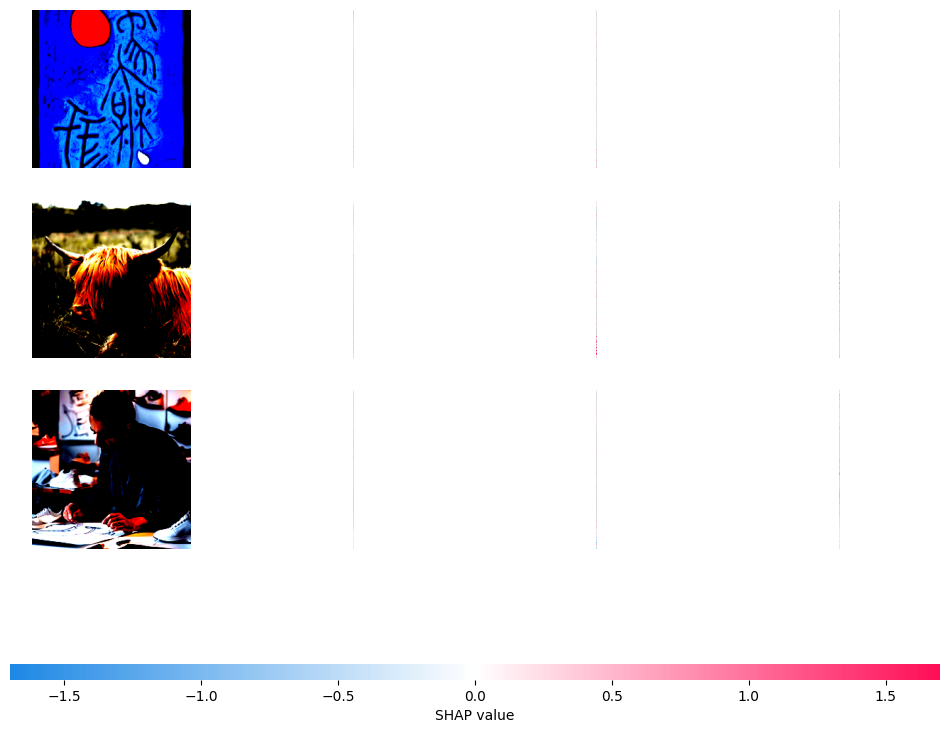

In [18]:
import torch
import shap
import numpy as np

# ✅ Load your trained model
model = Model()  # Replace with your actual model class
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

# ✅ Get some sample images from your dataset
images = [train_dataset[i][0] for i in range(100)]  # Only take the image, not the label
images_tensor = torch.stack(images)  # Shape: [50, C, H, W]

# ✅ Choose background samples (as torch tensor with requires_grad)
background_tensor = images_tensor[np.random.choice(images_tensor.shape[0], 20, replace=False)].clone()
background_tensor.requires_grad = True  # Required for the explainer

# ✅ Create a small test set to explain (use 3 samples to match SHAP output)
test_samples = images_tensor[:3]
test_samples.requires_grad = True

# ✅ Convert test_samples to NumPy in channels-last format for SHAP plots
X_numpy = test_samples.detach().cpu().permute(0, 2, 3, 1).numpy()

# ✅ Initialize the SHAP GradientExplainer with tensor input
explainer = shap.GradientExplainer(model, background_tensor)

# ✅ Compute SHAP values (disable additivity check if needed)
shap_values = explainer.shap_values(test_samples)

# ✅ Convert SHAP values to channels-last format.
# SHAP returns a list (one element per model output) with shape (N, C, H, W);
# we transpose each to shape (N, H, W, C)
shap_values = [sv.transpose(0, 2, 3, 1) for sv in shap_values]

# ✅ Plot SHAP values
shap.image_plot(shap_values, X_numpy)


In [32]:
 # Explain first 100 samplesimport torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage

def generate_gradcam(model, input_tensor, target_class=None):
    model.eval()
    
    # Hook for gradients & activations
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Save grad from conv layer

    def forward_hook(module, input, output):
        activations.append(output)  # Save activation from conv layer

    # Register hooks
    handle_b = model.conv_after_levit.register_backward_hook(backward_hook)
    handle_f = model.conv_after_levit.register_forward_hook(forward_hook)

    # Forward pass
    output = model(input_tensor)
    
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    # Get the activations and gradients
    grads_val = gradients[0].detach().cpu()
    activations_val = activations[0].detach().cpu()

    # Global average pooling of gradients
    weights = grads_val.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]

    # Weighted sum of activations
    gradcam_map = F.relu((weights * activations_val).sum(dim=1, keepdim=True))  # [B, 1, H, W]

    # Normalize heatmap
    gradcam_map = F.interpolate(gradcam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
    gradcam_map -= gradcam_map.min()
    gradcam_map /= gradcam_map.max()

    # Cleanup hooks
    handle_b.remove()
    handle_f.remove()

    return gradcam_map

# Helper to visualize
def visualize_gradcam(gradcam, image_tensor, label):
    heatmap = gradcam.squeeze().numpy()
    img = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    # Convert to RGB if needed
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=2)

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(label)
    plt.show()



/tmp/ipykernel_1555/1822540890.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(images).unsqueeze(0)  # Shape: [50, C, H, W]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


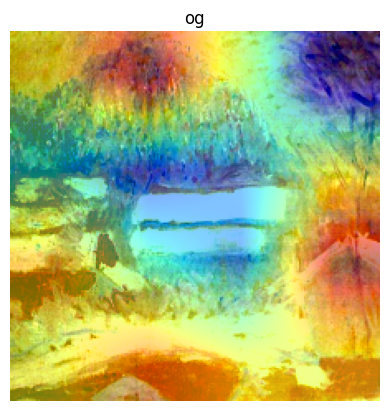

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


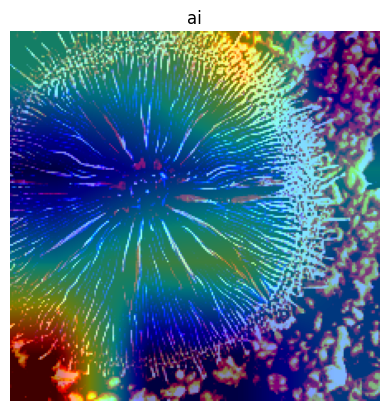

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


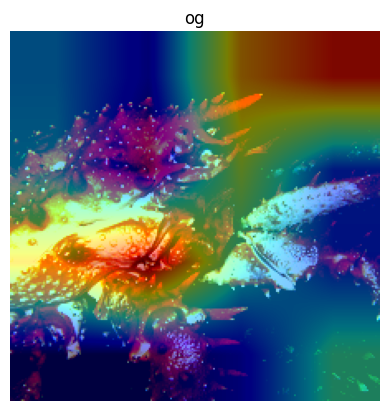

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


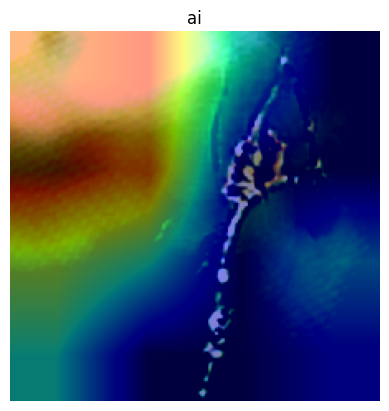

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


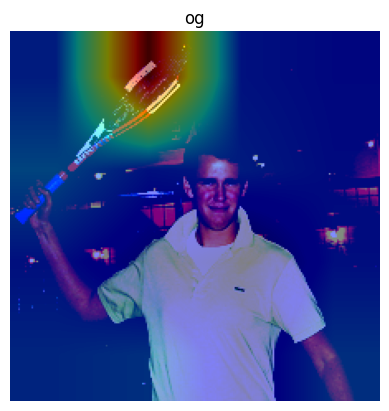

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


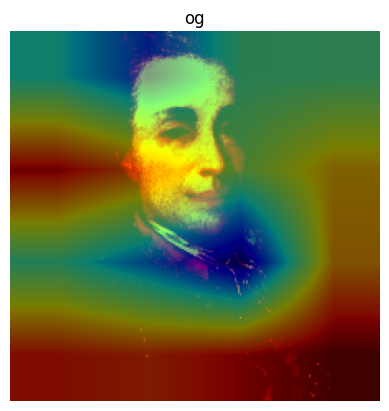

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


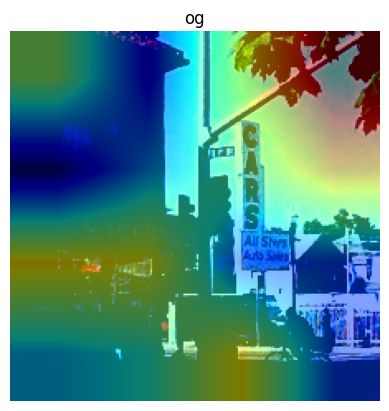

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


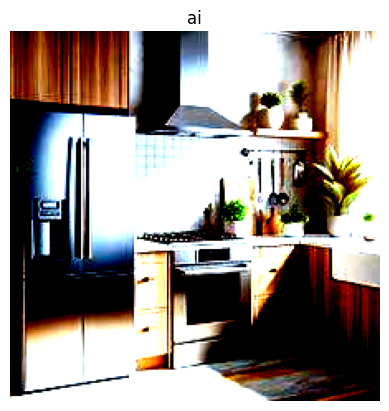

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


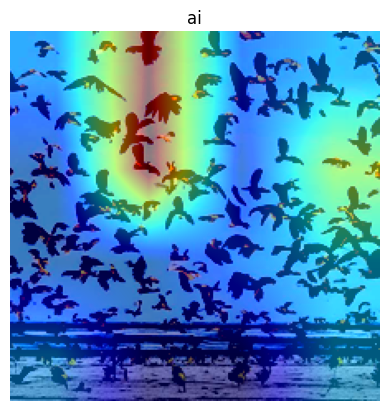

In [36]:
# Assuming you have a preprocessed image tensor: input_tensor [1, 3, H, W]
model = Model()
model.load_state_dict(torch.load('model_weights.pth'))
n_rows = 3
n_cols = 3

for i in range(n_rows):
    for j in range(n_cols):
        data = train_dataset[np.random.randint(0, len(train_dataset))]
        images = data[0]  # Only take the image, not the label
        input_tensor = torch.tensor(images).unsqueeze(0)  # Shape: [50, C, H, W]
        gradcam_map = generate_gradcam(model, input_tensor)
        visualize_gradcam(gradcam_map, input_tensor, "ai" if data[1].item() == 0 else "og")
